Reproduce the ["R from Python" plot](https://github.com/WinVector/Examples/blob/main/calling_R_from_Python/plot_from_R_example.ipynb) in Python using plotnine. This is a line for line tranlation of [significance_power_visuals.R](https://github.com/WinVector/Examples/blob/main/calling_R_from_Python/significance_power_visuals.R).

In [10]:
# import our modules
import numpy as np
import pandas as pd
from scipy.stats import norm
from data_algebra.cdata import RecordSpecification
from plotnine import (
    aes, 
    ggplot, 
    geom_line, geom_point, geom_ribbon, geom_vline,
    scale_color_manual, scale_fill_manual,
    xlab, ylab,
    ggtitle,
    theme
)

In [11]:
# our parameters of interest
n = 557
r = 0.1
t = 0.061576
power = 0.9
significance = 0.02

In [12]:
# convert to what were the fuction arguments
stdev = np.sqrt(0.5 / n)
effect_size = r
threshold = t
title='Area under the tails give you significance and (1-power)'
subtitle = 'Significance: control right tail; (1-Power): treatment left tail'
eps=1e-6
control_color='#d95f02'
treatment_color='#1b9e77'

In [13]:
# define the wide plotting frame
x = set(np.arange(-5 * stdev, 5 * stdev + effect_size, step=stdev / 100))
x.update([threshold, threshold-eps, threshold+eps])
x = sorted(x)

pframe = pd.DataFrame({
    'x': x,
    'control': norm.pdf(x, loc=0, scale=stdev),
    'treatment': norm.pdf(x, loc=effect_size, scale=stdev),
})
# control's right tail
pframe['control_tail'] = np.where(pframe['x'] > threshold, pframe['control'], 0)
# treatment's left tail
pframe['treatment_tail'] = np.where(pframe['x'] <= threshold, pframe['treatment'], 0)

pframe

,x,control,treatment,control_tail,treatment_tail
0,-0.149805,4.962170e-05,1.069071e-14,0.000000e+00,1.069071e-14
1,-0.149506,5.216325e-05,1.161969e-14,0.000000e+00,1.161969e-14
2,-0.149206,5.482949e-05,1.262815e-14,0.000000e+00,1.262815e-14
3,-0.148907,5.762625e-05,1.372275e-14,0.000000e+00,1.372275e-14
4,-0.148607,6.055961e-05,1.491073e-14,0.000000e+00,1.491073e-14
...,...,...,...,...,...
1332,0.248377,1.588927e-14,6.290411e-05,1.588927e-14,0.000000e+00
1333,0.248677,1.462444e-14,5.986178e-05,1.462444e-14,0.000000e+00
1334,0.248977,1.345895e-14,5.696089e-05,1.345895e-14,0.000000e+00
1335,0.249276,1.238510e-14,5.419515e-05,1.238510e-14,0.000000e+00


In [14]:
# convert from to long for for plotting using the data algebra

# specify the cdata record transform
record_transform = RecordSpecification(
    pd.DataFrame({
        'group': ['treatment', 'control'],
        'y': ['treatment', 'control'],
        'tail': ['treatment_tail', 'control_tail'],
    }),
    record_keys=['x'],
    control_table_keys=['group'],
).map_from_rows()

record_transform

RecordMap: transforming records of the form:
      record id            value                                       \
              x        treatment        control        treatment_tail   
0  x record key  treatment value  control value  treatment_tail value   

                       
         control_tail  
0  control_tail value  
to records of the form:
      record id record structure            value                      
              x            group                y                  tail
0  x record key          control    control value    control_tail value
1  x record key        treatment  treatment value  treatment_tail value

In [15]:
# apply the record transform
pframelong = record_transform(pframe)

pframelong

,x,group,y,tail
0,-0.149805,control,4.962170e-05,0.000000e+00
1,-0.149805,treatment,1.069071e-14,1.069071e-14
2,-0.149506,control,5.216325e-05,0.000000e+00
3,-0.149506,treatment,1.161969e-14,1.161969e-14
4,-0.149206,control,5.482949e-05,0.000000e+00
...,...,...,...,...
2669,0.248977,treatment,5.696089e-05,0.000000e+00
2670,0.249276,control,1.238510e-14,1.238510e-14
2671,0.249276,treatment,5.419515e-05,0.000000e+00
2672,0.249576,control,1.139579e-14,1.139579e-14


In [16]:
record_transform(pframe)

,x,group,y,tail
0,-0.149805,control,4.962170e-05,0.000000e+00
1,-0.149805,treatment,1.069071e-14,1.069071e-14
2,-0.149506,control,5.216325e-05,0.000000e+00
3,-0.149506,treatment,1.161969e-14,1.161969e-14
4,-0.149206,control,5.482949e-05,0.000000e+00
...,...,...,...,...
2669,0.248977,treatment,5.696089e-05,0.000000e+00
2670,0.249276,control,1.238510e-14,1.238510e-14
2671,0.249276,treatment,5.419515e-05,0.000000e+00
2672,0.249576,control,1.139579e-14,1.139579e-14


In [17]:
# limit down to non-rare region
pframelong = (
    pframelong
        .loc[pframelong["y"] > 1e-6, :]
        .reset_index(drop=True, inplace=False)
)


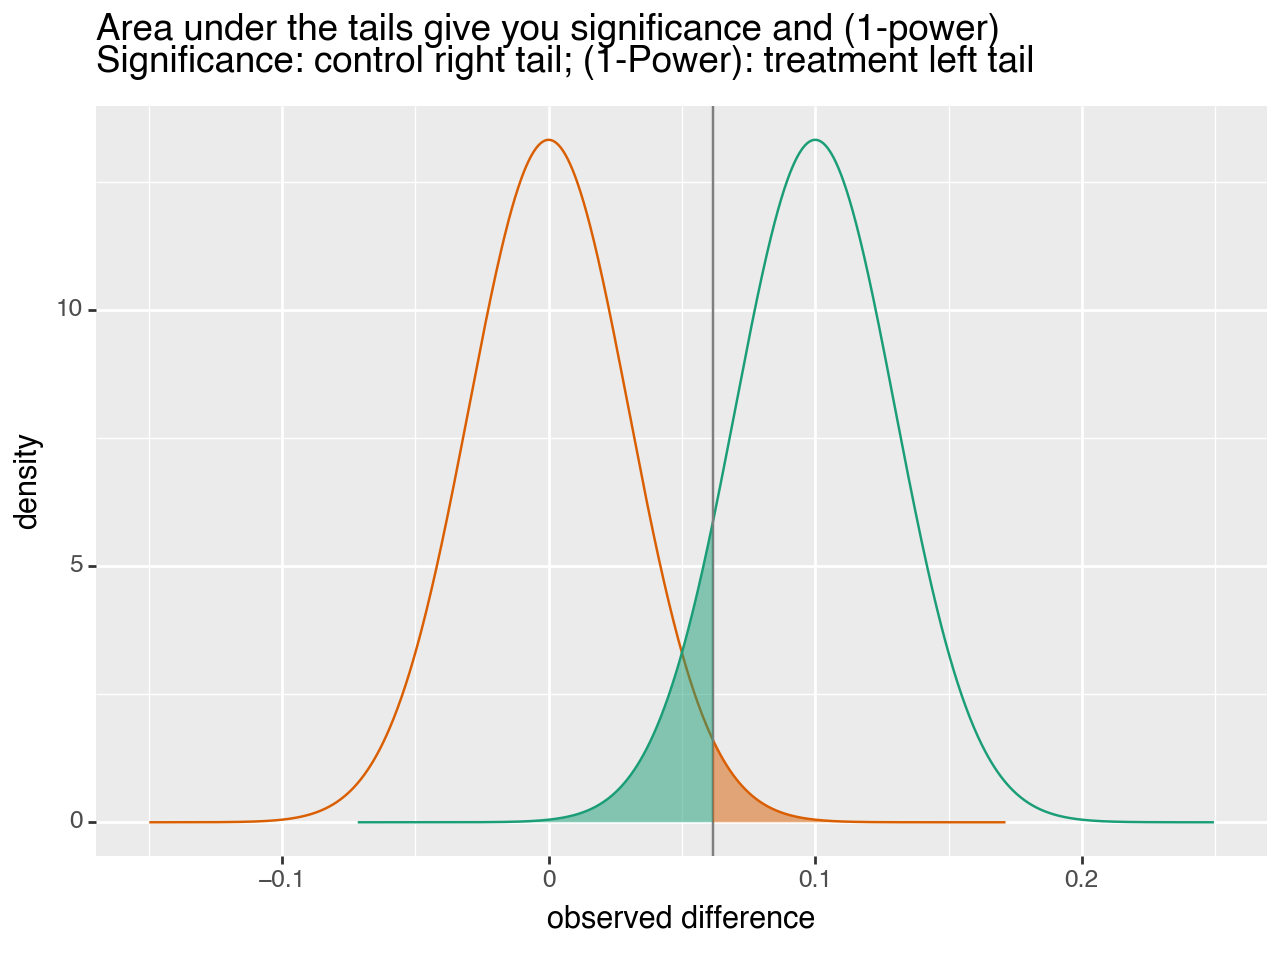

<Figure Size: (640 x 480)>

In [18]:
# make the plot
palette = {'control': control_color, 'treatment': treatment_color}
p = (
    ggplot(pframelong, aes(x='x', y='y'))
        + geom_line(aes(color='group'))
        + geom_vline(xintercept=threshold, 
                     color='#7f7f7f', 
                     # linewidth=1,
                     )
        + geom_ribbon(aes(ymin=0, ymax='tail', fill='group'), alpha = 0.5)
        + scale_color_manual(values=palette)
        + scale_fill_manual(values=palette)
        + theme(legend_position='none')
        + ylab('density')
        + xlab('observed difference')
        + ggtitle(
            title 
            + "\n" + subtitle,
            )
    )

p